In [7]:
import pandas as pd
import numpy as np

####################################################################################################
### Select SSIC Hierarchical Level

# 1. 'Section'
# 2. 'Division'
# 3. 'Group'
# 4. 'Class'
# 5. 'Subclass'

level = 'Subclass' 
####################################################################################################

# create ssic denormalized fact table
ssic_detailed_def_filepath = r"dataSources/DoS/ssic2020-detailed-definitions.xlsx"
ssic_alpha_index_filepath = r"dataSources/DoS/ssic2020-alphabetical-index.xlsx"

df_detailed_def = pd.read_excel(ssic_detailed_def_filepath, skiprows=4)
df_alpha_index = pd.read_excel(ssic_alpha_index_filepath, dtype=str, skiprows=5)
df_alpha_index = df_alpha_index.drop(df_alpha_index.columns[2], axis=1).dropna().rename(columns={'SSIC 2020': 'SSIC 2020','SSIC 2020 Alphabetical Index Description': 'Detailed Definitions'})

df_concat = pd.concat([df_detailed_def, df_alpha_index])

####################################################################################################
### Select which fact table to train/transform
# - df_detailed_def
# - df_concat       (concat of df_detailed_def and df_alpha_index)

df_data_dict = df_detailed_def 
####################################################################################################

# prep ssic_n tables for joining/merging and reference
# Section, 1-alpha 
ssic_1_raw = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 1)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code']) 
ssic_1_raw['Groups Classified Under this Code'] = ssic_1_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_1 = ssic_1_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_1['Groups Classified Under this Code'] = ssic_1['Groups Classified Under this Code'].str.replace('•', '')
ssic_1['Section, 2 digit code'] = ssic_1['Groups Classified Under this Code'].str[0:2]
ssic_1 = ssic_1.rename(columns={'SSIC 2020': 'Section','SSIC 2020 Title': 'Section Title'})

# Division, 2-digit
ssic_2_raw = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 2)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code'])
ssic_2_raw['Groups Classified Under this Code'] = ssic_2_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_2 = ssic_2_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_2['Groups Classified Under this Code'] = ssic_2['Groups Classified Under this Code'].str.replace('•', '')
ssic_2 = ssic_2.rename(columns={'SSIC 2020': 'Division','SSIC 2020 Title': 'Division Title'}).drop(columns=['Groups Classified Under this Code']).drop_duplicates()

# Group, 3-digit 
ssic_3_raw = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 3)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code'])
ssic_3_raw['Groups Classified Under this Code'] = ssic_3_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_3 = ssic_3_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_3['Groups Classified Under this Code'] = ssic_3['Groups Classified Under this Code'].str.replace('•', '')
ssic_3 = ssic_3.rename(columns={'SSIC 2020': 'Group','SSIC 2020 Title': 'Group Title'}).drop(columns=['Groups Classified Under this Code']).drop_duplicates()

# Class, 4-digit
ssic_4_raw = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 4)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code'])
ssic_4_raw['Groups Classified Under this Code'] = ssic_4_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_4 = ssic_4_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_4['Groups Classified Under this Code'] = ssic_4['Groups Classified Under this Code'].str.replace('•', '')
ssic_4 = ssic_4.rename(columns={'SSIC 2020': 'Class','SSIC 2020 Title': 'Class Title'}).drop(columns=['Groups Classified Under this Code']).drop_duplicates()

# Sub-class, 5-digit
ssic_5 = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 5)].reset_index(drop=True).drop(columns=['Groups Classified Under this Code'])
ssic_5.replace('<Blank>', '', inplace=True)
ssic_5.replace('NaN', '', inplace=True)

# prep join columns
ssic_5['Section, 2 digit code'] = ssic_5['SSIC 2020'].astype(str).str[:2]
ssic_5['Division'] = ssic_5['SSIC 2020'].astype(str).str[:2]
ssic_5['Group'] = ssic_5['SSIC 2020'].astype(str).str[:3]
ssic_5['Class'] = ssic_5['SSIC 2020'].astype(str).str[:4]

# join ssic_n Hierarhical Layer Tables (Section, Division, Group, Class, Sub-Class)
ssic_df = pd.merge(ssic_5, ssic_1[['Section', 'Section Title', 'Section, 2 digit code']], on='Section, 2 digit code', how='left')
ssic_df = pd.merge(ssic_df, ssic_2[['Division', 'Division Title']], on='Division', how='left')
ssic_df = pd.merge(ssic_df, ssic_3[['Group', 'Group Title']], on='Group', how='left')
ssic_df = pd.merge(ssic_df, ssic_4[['Class', 'Class Title']], on='Class', how='left')

####################################################################################################
# mapping
level_map = {
    'Section': ('Section', ssic_df.iloc[:, [0, 1, 9, 10, 11, 12, 13]].drop_duplicates(), ssic_1.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_section_classifier", ssic_1),
    'Division': ('Division', ssic_df.iloc[:, [0, 1, 6, 10, 11, 12, 13]].drop_duplicates(), ssic_2.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_division_classifier", ssic_2),
    'Group': ('Group', ssic_df.iloc[:, [0, 1, 7, 10, 11, 12, 13]].drop_duplicates(), ssic_3.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_group_classifier", ssic_3),
    'Class': ('Class', ssic_df.iloc[:, [0, 1, 8, 10, 11, 12, 13]].drop_duplicates(), ssic_4.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_class_classifier", ssic_4),
    'Subclass': ('SSIC 2020', ssic_df.iloc[:, [0, 1, 9, 10, 11, 12, 13]].drop_duplicates(), ssic_5.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_subclass_classifier", ssic_5)
}

def get_variables(level):
    # Get the tuple for the specified level
    level_tuple = level_map.get(level)
    
    # If the level is not found in the level_map, raise an exception
    if level_tuple is None:
        raise ValueError(f"Level '{level}' not found in level_map.")
    
    variable1 = level_tuple[0]  # This will be the level specified (e.g., 'Section')
    previous_level = level_tuple[-1]  # This will be the previous level in the map
    
    # Determine variable2 based on previous_level
    variable2 = None if previous_level == '0' else level_map[previous_level][0]
    
    return variable1, variable2


# Get the values for a and b based on the lvl_train
lvl_train, df_streamlit, ssic_n_sl, model, ssic_lvl = level_map.get(level, ('default_a', 'default_b', 'default_c', 'default_d', 'default_e'))
lvl_train_title = lvl_train + " Title"

# prep ssic_n dictionary df_prep
df_prep = ssic_df[[lvl_train, 'Detailed Definitions']]
df_prep['encoded_cat'] = df_prep[lvl_train].astype('category').cat.codes
df_prep = df_prep[[lvl_train, 'encoded_cat']].drop_duplicates()


# load model directly from huggingface
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained(model)
model = TFAutoModelForSequenceClassification.from_pretrained(model)

###############################################################################################################################################
# Indicate list of Top N predictions for scoring 
top_n_predictions = 10
###############################################################################################################################################

# Define the function to predict scores and categories
def predict_text(text, top_n=top_n_predictions):
    # Tokenize the input text
    predict_input = tokenizer.encode(
        text,
        truncation=True,
        padding=True,
        return_tensors="tf"
    )
    
    # Get the model output
    output = model(predict_input)[0]
    output_array = output.numpy()[0]  # Get the first (and only) output for this input

    ############################################################################################################################################### 
    
    # Get the top n scores and their corresponding categories
    top_n_indices = output_array.argsort()[-top_n:][::-1]
    top_n_scores = output_array[top_n_indices]
    top_n_categories = top_n_indices

    # Prepare the merged DataFrame
    lvl_dict = df_prep[[lvl_train, 'encoded_cat']].drop_duplicates()
    lvl_ref = ssic_lvl[[lvl_train, lvl_train_title]].drop_duplicates()
    merged_df = lvl_dict.merge(lvl_ref, on=lvl_train, how='left')

    # Create a DataFrame for the top predictions
    sorted_output_df = pd.DataFrame({
        'encoded_cat': top_n_categories,
        'value': top_n_scores
    })
    
    # Merge the top predictions with the merged DataFrame
    merged_df2 = sorted_output_df.merge(merged_df, on='encoded_cat', how='left')

    # Return the results as a list of dictionaries
    # return final_merged_df[['value', lvl_train, lvl_train_title, oneup_lvl_train, oneup_lvl_train_title]]
    # return final_merged_df[['value', lvl_train, lvl_train_title, oneup_lvl_train, oneup_lvl_train_title]].to_dict(orient='records')
    return merged_df2[['value', lvl_train, lvl_train_title]].to_dict(orient='records')



C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: 'SSIC2020 Detailed Definitions'!$A:$E.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")
C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\royle\AppData\Local\Temp\ipykernel_317

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at nusebacra/ssicsync_subclass_classifier.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [2]:
test_text = '''
principal activities of the Company are the manufacture of ice cream, the operation of Swensen s ice cream parlours cum restaurants, operation of other specialty restaurants and investment holding.

'''

# Use the function to get predictions
predict_text(test_text, top_n=3)



[{'value': -8.249249458312988,
  'SSIC 2020': '11030',
  'SSIC 2020 Title': 'Manufacture of malt liquors and malt (e.g. beer and stout)'},
 {'value': -8.474306106567383,
  'SSIC 2020': '10509',
  'SSIC 2020 Title': 'Manufacture of dairy products n.e.c. (e.g. butter, cheese, ice-cream mixes and powder, yoghurt)'},
 {'value': -8.873909950256348,
  'SSIC 2020': '56121',
  'SSIC 2020 Title': 'Fast food outlets'}]

In [4]:
test_text = '''
the manufacture of ice cream, the operation of Swensen s ice cream parlours cum restaurants, operation of other specialty restaurants and investment holding.
 

'''

# Use the function to get predictions
predict_text(test_text, top_n=3)



[{'value': -8.265595436096191,
  'SSIC 2020': '56121',
  'SSIC 2020 Title': 'Fast food outlets'},
 {'value': -8.927659034729004,
  'SSIC 2020': '56140',
  'SSIC 2020 Title': 'Stalls selling cooked food and prepared drinks (including stalls at food courts and mobile food hawkers)'},
 {'value': -9.216270446777344,
  'SSIC 2020': '11030',
  'SSIC 2020 Title': 'Manufacture of malt liquors and malt (e.g. beer and stout)'}]

In [3]:
###############################################################################################################################################
# Test with List of 102

import pandas as pd
import os

list_102 = r"dataSources\ScrapedOutputFiles\(Roy) List of 90 Coy and SSIC.csv"
list_102_AR_filename = r"dataSources\ScrapedOutputFiles\(Roy) extracted_notes_pages_with_uen.xlsx"

df_list_102 = pd.read_csv(list_102, dtype = str)
df_list_102_AR = pd.read_excel(list_102_AR_filename, dtype = str)

df_list_102_merged = pd.merge(df_list_102, df_list_102_AR, left_on='UEN', right_on='UEN Number')

# ssic_code 1
df_list_102_merged['Division'] = df_list_102_merged['ssic_code'].astype(str).str[:2]
df_list_102_merged['Group'] = df_list_102_merged['ssic_code'].astype(str).str[:3]
df_list_102_merged['Class'] = df_list_102_merged['ssic_code'].astype(str).str[:4]
df_list_102_merged['Sub-class'] = df_list_102_merged['ssic_code'].astype(str).str[:5]
df_list_102_merged = pd.merge(df_list_102_merged, ssic_1[['Section, 2 digit code', 'Section']], left_on='Division', right_on='Section, 2 digit code', how='left')
df_list_102_merged.drop(columns=['Section, 2 digit code'], inplace=True)

# ssic_code 2
df_list_102_merged['Division2'] = df_list_102_merged['ssic_code2'].astype(str).str[:2]
df_list_102_merged['Group2'] = df_list_102_merged['ssic_code2'].astype(str).str[:3]
df_list_102_merged['Class2'] = df_list_102_merged['ssic_code2'].astype(str).str[:4]
df_list_102_merged['Sub-class2'] = df_list_102_merged['ssic_code2'].astype(str).str[:5]
df_list_102_merged = pd.merge(df_list_102_merged, ssic_1[['Section, 2 digit code', 'Section']].rename(columns={'Section': 'Section2'}), left_on='Division2', right_on='Section, 2 digit code', how='left')
df_list_102_merged.drop(columns=['Section, 2 digit code'], inplace=True)

# df_list_102_merged[['Notes Page Content']]

###############################################################################################################################################
# TDIDF

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import nltk
nltk.download('stopwords')
import re
# nltk.download()
from nltk.corpus import stopwords

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    words_to_remove = ['principal', 'activities', 'investment', 'holding', 'holdings', 'singapore', 'exchange', 'securities', 'trading', 'limited', 'company']  # List of additional words to remove############################################################
    # Remove additional words
    if words_to_remove:
        text = ' '.join(word for word in text.split() if word not in words_to_remove)
    return text

df_list_102_merged['Notes Page Content2'] = df_list_102_merged['Notes Page Content'].apply(preprocess_text)

tfidf_vectorizer = TfidfVectorizer(
    # # max_df=0.8,         # Ignore terms that appear in more than 80% of documents
    # # min_df=2,           # Ignore terms that appear in fewer than 2 documents
    # max_features=1000,  # Consider only the top 1000 terms by TF-IDF score
    # ngram_range=(1, 2), # Include both unigrams and bigrams
    # stop_words='english' # Remove standard English stop words
)

# Fit and transform the preprocessed text ('Notes Page Content2')
tfidf_matrix = tfidf_vectorizer.fit_transform(df_list_102_merged['Notes Page Content2'])

# Get feature names (terms)
terms = tfidf_vectorizer.get_feature_names_out()

# Set a TF-IDF threshold
tfidf_threshold = 0.1

# Function to get important terms from a document
def get_important_terms(doc_index, tfidf_matrix, terms, threshold, top_tokens=10):
    term_scores = tfidf_matrix[doc_index].toarray().flatten()
    important_term_indices = term_scores >= threshold
    
    # Filter terms based on threshold and preserve original order
    important_terms = [terms[i] for i in range(len(terms)) if important_term_indices[i]]
    
    # Retrieve original order from 'Notes Page Content2'
    original_text = df_list_102_merged.at[doc_index, 'Notes Page Content2'].split()
    important_terms_in_order = [term for term in original_text if term in important_terms]

    # Get the first 'top_tokens' tokens
    first_10_tokens = important_terms_in_order[:top_tokens]
    
    return ' '.join(first_10_tokens )

# Apply the function to each document in the DataFrame
df_list_102_merged['Notes Page Content2'] = [
    get_important_terms(i, tfidf_matrix, terms, tfidf_threshold)
    for i in range(tfidf_matrix.shape[0])
]

df_list_102_merged[['entity_name', 'Notes Page Content', 'Notes Page Content2']]

# Save the selected columns to a CSV file
excel_file_path = 'dataSources\ScrapedOutputFiles\(Roy) data validation.xlsx'
df_list_102_merged.to_excel(excel_file_path, index=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\royle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


PermissionError: [Errno 13] Permission denied: 'dataSources\\ScrapedOutputFiles\\(Roy) data validation.xlsx'

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: 'SSIC2020 Detailed Definitions'!$A:$E.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")
C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\royle\AppData\Local\Temp\ipykernel_317

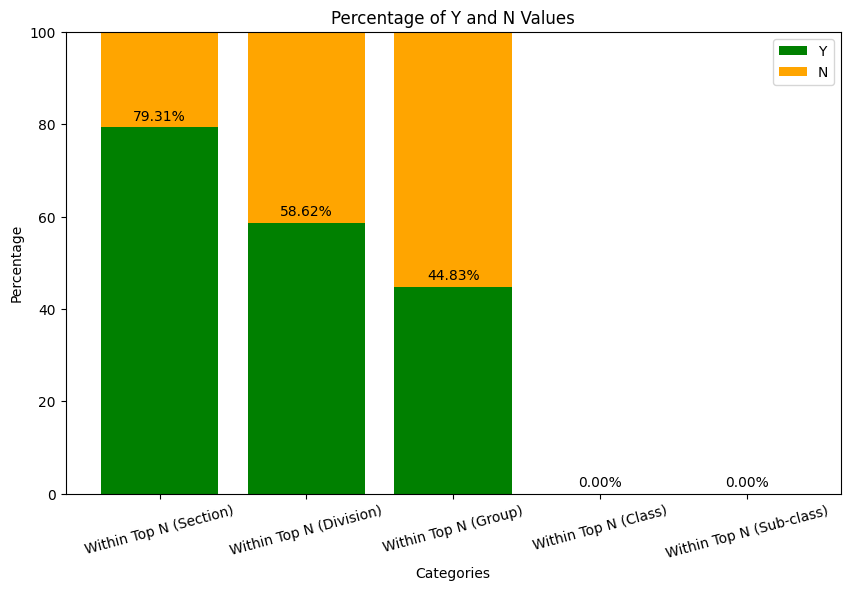

In [31]:
# qwert 

import pandas as pd
import numpy as np

####################################################################################################
### Select SSIC Hierarchical Level

# 1. 'Section'
# 2. 'Division'
# 3. 'Group'
# 4. 'Class'
# 5. 'Subclass'

level = 'Group' 
####################################################################################################

# create ssic denormalized fact table
ssic_detailed_def_filepath = r"dataSources/DoS/ssic2020-detailed-definitions.xlsx"
ssic_alpha_index_filepath = r"dataSources/DoS/ssic2020-alphabetical-index.xlsx"

df_detailed_def = pd.read_excel(ssic_detailed_def_filepath, skiprows=4)
df_alpha_index = pd.read_excel(ssic_alpha_index_filepath, dtype=str, skiprows=5)
df_alpha_index = df_alpha_index.drop(df_alpha_index.columns[2], axis=1).dropna().rename(columns={'SSIC 2020': 'SSIC 2020','SSIC 2020 Alphabetical Index Description': 'Detailed Definitions'})

df_concat = pd.concat([df_detailed_def, df_alpha_index])

####################################################################################################
### Select which fact table to train/transform
# - df_detailed_def
# - df_concat       (concat of df_detailed_def and df_alpha_index)

df_data_dict = df_detailed_def 
####################################################################################################

# prep ssic_n tables for joining/merging and reference
# Section, 1-alpha 
ssic_1_raw = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 1)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code']) 
ssic_1_raw['Groups Classified Under this Code'] = ssic_1_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_1 = ssic_1_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_1['Groups Classified Under this Code'] = ssic_1['Groups Classified Under this Code'].str.replace('•', '')
ssic_1['Section, 2 digit code'] = ssic_1['Groups Classified Under this Code'].str[0:2]
ssic_1 = ssic_1.rename(columns={'SSIC 2020': 'Section','SSIC 2020 Title': 'Section Title'})

# Division, 2-digit
ssic_2_raw = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 2)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code'])
ssic_2_raw['Groups Classified Under this Code'] = ssic_2_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_2 = ssic_2_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_2['Groups Classified Under this Code'] = ssic_2['Groups Classified Under this Code'].str.replace('•', '')
ssic_2 = ssic_2.rename(columns={'SSIC 2020': 'Division','SSIC 2020 Title': 'Division Title'}).drop(columns=['Groups Classified Under this Code']).drop_duplicates()

# Group, 3-digit 
ssic_3_raw = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 3)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code'])
ssic_3_raw['Groups Classified Under this Code'] = ssic_3_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_3 = ssic_3_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_3['Groups Classified Under this Code'] = ssic_3['Groups Classified Under this Code'].str.replace('•', '')
ssic_3 = ssic_3.rename(columns={'SSIC 2020': 'Group','SSIC 2020 Title': 'Group Title'}).drop(columns=['Groups Classified Under this Code']).drop_duplicates()

# Class, 4-digit
ssic_4_raw = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 4)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code'])
ssic_4_raw['Groups Classified Under this Code'] = ssic_4_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_4 = ssic_4_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_4['Groups Classified Under this Code'] = ssic_4['Groups Classified Under this Code'].str.replace('•', '')
ssic_4 = ssic_4.rename(columns={'SSIC 2020': 'Class','SSIC 2020 Title': 'Class Title'}).drop(columns=['Groups Classified Under this Code']).drop_duplicates()

# Sub-class, 5-digit
ssic_5 = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 5)].reset_index(drop=True).drop(columns=['Groups Classified Under this Code'])
ssic_5.replace('<Blank>', '', inplace=True)
ssic_5.replace('NaN', '', inplace=True)

# prep join columns
ssic_5['Section, 2 digit code'] = ssic_5['SSIC 2020'].astype(str).str[:2]
ssic_5['Division'] = ssic_5['SSIC 2020'].astype(str).str[:2]
ssic_5['Group'] = ssic_5['SSIC 2020'].astype(str).str[:3]
ssic_5['Class'] = ssic_5['SSIC 2020'].astype(str).str[:4]

# join ssic_n Hierarhical Layer Tables (Section, Division, Group, Class, Sub-Class)
ssic_df = pd.merge(ssic_5, ssic_1[['Section', 'Section Title', 'Section, 2 digit code']], on='Section, 2 digit code', how='left')
ssic_df = pd.merge(ssic_df, ssic_2[['Division', 'Division Title']], on='Division', how='left')
ssic_df = pd.merge(ssic_df, ssic_3[['Group', 'Group Title']], on='Group', how='left')
ssic_df = pd.merge(ssic_df, ssic_4[['Class', 'Class Title']], on='Class', how='left')

# prep ssic_n dictionary df_prep
df_prep = ssic_df[[lvl_train, 'Detailed Definitions']]
df_prep['encoded_cat'] = df_prep[lvl_train].astype('category').cat.codes
df_prep = df_prep[[lvl_train, 'encoded_cat']].drop_duplicates()

# mapping
level_map = {
    'Section': ('Section', ssic_df.iloc[:, [0, 1, 9, 10, 11, 12, 13]].drop_duplicates(), ssic_1.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_section_classifier", ssic_1),
    'Division': ('Division', ssic_df.iloc[:, [0, 1, 6, 10, 11, 12, 13]].drop_duplicates(), ssic_2.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_division_classifier", ssic_2),
    'Group': ('Group', ssic_df.iloc[:, [0, 1, 7, 10, 11, 12, 13]].drop_duplicates(), ssic_3.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_group_classifier", ssic_3),
    'Class': ('Class', ssic_df.iloc[:, [0, 1, 8, 10, 11, 12, 13]].drop_duplicates(), ssic_4.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_class_classifier", ssic_4),
    'Subclass': ('SSIC 2020', ssic_df.iloc[:, [0, 1, 9, 10, 11, 12, 13]].drop_duplicates(), ssic_5.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_subclass_classifier", ssic_5)
}

# Get the values for a and b based on the lvl_train
lvl_train, df_streamlit, ssic_n_sl, model, ssic_lvl = level_map.get(level, ('default_a', 'default_b', 'default_c', 'default_d', 'default_e', 'default_f'))
lvl_train_title = lvl_train + " Title"

# load model directly from huggingface
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained(model)
model = TFAutoModelForSequenceClassification.from_pretrained(model)

# Define the function to predict scores and categories
def predict_text(text, top_n=15):
    # Tokenize the input text
    predict_input = tokenizer.encode(
        text,
        truncation=True,
        padding=True,
        return_tensors="tf"
    )
    
    # Get the model output
    output = model(predict_input)[0]
    output_array = output.numpy()[0]  # Get the first (and only) output for this input

    ############################################################################################################################################### 
    
    # Get the top n scores and their corresponding categories
    top_n_indices = output_array.argsort()[-top_n:][::-1]
    top_n_scores = output_array[top_n_indices]
    top_n_categories = top_n_indices

    # Prepare the merged DataFrame
    lvl_dict = df_prep[[lvl_train, 'encoded_cat']].drop_duplicates()
    lvl_ref = ssic_lvl[[lvl_train, lvl_train_title]].drop_duplicates()
    merged_df = lvl_dict.merge(lvl_ref, on=lvl_train, how='left')

    # Create a DataFrame for the top predictions
    sorted_output_df = pd.DataFrame({
        'encoded_cat': top_n_categories,
        'value': top_n_scores
    })
    
    # Merge the top predictions with the merged DataFrame
    merged_df2 = sorted_output_df.merge(merged_df, on='encoded_cat', how='left')

    # Return the results as a list of dictionaries
    # return final_merged_df[['value', lvl_train, lvl_train_title]].to_dict(orient='records')
    return merged_df2[['value', lvl_train, lvl_train_title]].to_dict(orient='records')





import pandas as pd
list_df_filepath = r"dataSources\ScrapedOutputFiles\(Roy) List of 90 Coy and SSIC.csv"
list_df = pd.read_csv(list_df_filepath, dtype = str)

# Create new columns
list_df['Division'] = list_df['ssic_code'].str[:2]
list_df['Group'] = list_df['ssic_code'].str[:3]
list_df['Class'] = list_df['ssic_code'].str[:4]
list_df['Sub-class'] = list_df['ssic_code']

list_df['Division2'] = list_df['ssic_code2'].str[:2]
list_df['Group2'] = list_df['ssic_code2'].str[:3]
list_df['Class2'] = list_df['ssic_code2'].str[:4]
list_df['Sub-class2'] = list_df['ssic_code2']

list_df = list_df.merge(ssic_1[['Section, 2 digit code', 'Section']], left_on='Division', right_on='Section, 2 digit code', how='left')
list_df = list_df.rename(columns={'Section': 'Section'})
list_df = list_df.merge(ssic_1[['Section, 2 digit code', 'Section']], left_on='Division2', right_on='Section, 2 digit code', how='left', suffixes=('', '2'))
list_df = list_df.rename(columns={'Section2': 'Section2'})

# Validation Data
# vdf_filepath = r"dataSources\ScrapedOutputFiles\(Roy) data validation.xlsx"
vdf_filepath = r"LLM_Test\Summarised_output_for_model.xlsx"
vdf = pd.read_excel(vdf_filepath, dtype = str)

vdf = vdf.merge(list_df[['UEN', 'ssic_code', 'ssic_code2', 'Section', 'Division', 'Group', 'Class', 'Sub-class', 'Section2', 'Division2', 'Group2', 'Class2', 'Sub-class2']], left_on='UEN Number', right_on='UEN', how='left')
# Replace empty strings with NaN
vdf = vdf.replace('', pd.NA)

# Drop rows with any NaN values
vdf = vdf.dropna()




# Create an empty list to store the predictions
predictions = []

# Iterate over each row of the DataFrame and apply the prediction function
for idx, row in vdf.iterrows():
    text = row['Philschmid_bart_tfidf']  
    #'Notes Page Content', 'Summarized_Description_azma_bart', 'Summarized_Description_facebook_bart', 'Summarized_Description_philschmid_bart'
    #'Azma_bart_tfidf'	'FB_bart_tfidf'	'Philschmid_bart_tfidf'	'Q&A model Output'

    result = predict_text(text)
    for pred in result:
        pred.update({
            'UEN': row['UEN Number'],
            'entity_name': row['PDF Name'],
            'ssic_code': row['ssic_code'],
            'ssic_code2': row['ssic_code2'],
            'Notes Page Content': row['Notes Page Content'],
            'Predicted Text': text,
            'm_Section': row['Section'],
            'm_Section2': row['Section' + "2"],
            'm_Division': row['Division'],
            'm_Division2': row['Division' + "2"],
            'm_Group': row['Group'],
            'm_Group2': row['Group' + "2"],
            'm_Class': row['Class'],
            'm_Class2': row['Class' + "2"],
            'm_Sub-class': row['Sub-class'],
            'm_Sub-class2': row['Sub-class' + "2"]
        })
        predictions.append(pred)

# Create a DataFrame from the list of predictions
prediction_df = pd.DataFrame(predictions)

# Extracting respective SSIC levels from Predictions
prediction_df['p_Section'] = prediction_df[lvl_train].apply(lambda x: x[:2] if len(x) >= 2 else np.nan)
prediction_df['p_Section'] = prediction_df['p_Section'].map(ssic_1.set_index('Section, 2 digit code')['Section'])
prediction_df['p_Division'] = prediction_df[lvl_train].apply(lambda x: x[:2] if len(x) >= 2 else np.nan)
prediction_df['p_Group'] = prediction_df[lvl_train].apply(lambda x: x[:3] if len(x) >= 3 else np.nan)
prediction_df['p_Class'] = prediction_df[lvl_train].apply(lambda x: x[:4] if len(x) >= 4 else np.nan)
prediction_df['p_Sub-class'] = prediction_df[lvl_train].apply(lambda x: x[:5] if len(x) >= 5 else np.nan)
prediction_df = prediction_df.fillna('NaN')

Section_prediction_df = prediction_df.groupby(['entity_name', 'ssic_code', 'ssic_code2', 'm_Section', 'm_Section2', 'Notes Page Content', 'Predicted Text'])['p_Section'].apply(list).reset_index()
Division_prediction_df = prediction_df.groupby(['entity_name', 'ssic_code', 'ssic_code2', 'm_Division', 'm_Division2', 'Notes Page Content', 'Predicted Text'])['p_Division'].apply(list).reset_index()
Group_prediction_df = prediction_df.groupby(['entity_name', 'ssic_code', 'ssic_code2', 'm_Group', 'm_Group2', 'Notes Page Content', 'Predicted Text'])['p_Group'].apply(list).reset_index()
Class_prediction_df = prediction_df.groupby(['entity_name', 'ssic_code', 'ssic_code2', 'm_Class', 'm_Class2', 'Notes Page Content', 'Predicted Text'])['p_Class'].apply(list).reset_index()
Subclass_prediction_df = prediction_df.groupby(['entity_name', 'ssic_code', 'ssic_code2', 'm_Sub-class', 'm_Sub-class2', 'Notes Page Content', 'Predicted Text'])['p_Sub-class'].apply(list).reset_index()

def check_alpha_in_list(row, N, m1, m2, p):
    # Check if p contains any NaN values
    if 'NaN' in row[p]:
        return None
    
    # Check if the alpha in the 1st column is in the first N elements of the list in the 3rd column
    if row[m1] in row[p][:N] or row[m2] in row[p][:N]:
        return 'Y'
    else:
        return 'N'
    

Section_prediction_df['Within Top N (Section)'] = Section_prediction_df.apply(check_alpha_in_list, axis=1, N=3, m1 = 'm_Section', m2 = 'm_Section2', p = 'p_Section')
Division_prediction_df['Within Top N (Division)'] = Division_prediction_df.apply(check_alpha_in_list, axis=1, N=3, m1 = 'm_Division', m2 = 'm_Division2', p = 'p_Division')
Group_prediction_df['Within Top N (Group)'] = Group_prediction_df.apply(check_alpha_in_list, axis=1, N=3, m1 = 'm_Group', m2 = 'm_Group2', p = 'p_Group')
Class_prediction_df['Within Top N (Class)'] = Class_prediction_df.apply(check_alpha_in_list, axis=1, N=3, m1 = 'm_Class', m2 = 'm_Class2', p = 'p_Class')
Subclass_prediction_df['Within Top N (Sub-class)'] = Subclass_prediction_df.apply(check_alpha_in_list, axis=1, N=3, m1 = 'm_Sub-class', m2 = 'm_Sub-class2', p = 'p_Sub-class')

dfs = [
    Section_prediction_df,
    Division_prediction_df,
    Group_prediction_df,
    Class_prediction_df,
    Subclass_prediction_df
]

# Merge DataFrames on entity_name, ssic_code, ssic_code2
merged_df = dfs[0]  # Start with the first DataFrame
for df in dfs[1:]:
    merged_df = pd.merge(merged_df, df, on=['entity_name', 'ssic_code', 'ssic_code2', 'Notes Page Content', 'Predicted Text'], how='outer')

columns_to_include = [
    'Within Top N (Section)',
    'Within Top N (Division)',
    'Within Top N (Group)',
    'Within Top N (Class)',
    'Within Top N (Sub-class)'
]

# Filter the DataFrame to include only the specified columns
filtered_df = merged_df[columns_to_include]

# Calculate percentage of 'Y' and 'N' in each column
percentages = {}
for column in filtered_df.columns:
    counts = filtered_df[column].value_counts(normalize=True) * 100
    percentages[column] = counts.reindex(['Y', 'N']).fillna(0)

# Create a DataFrame from percentages
percentages_df = pd.DataFrame(percentages).round(2)

# percentages_df

import matplotlib.pyplot as plt

# Transpose the DataFrame for vertical plotting
percentages_df_transposed = percentages_df.transpose()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the bars vertically
bars1 = ax.bar(percentages_df_transposed.index, percentages_df_transposed['Y'], color='green', label='Y')
bars2 = ax.bar(percentages_df_transposed.index, percentages_df_transposed['N'], bottom=percentages_df_transposed['Y'], color='orange', label='N')

# Adding data labels
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Customizing the plot
ax.set_title('Percentage of Y and N Values')
ax.set_xlabel('Categories')
ax.set_ylabel('Percentage')
ax.set_ylim(0, 100)
ax.legend()

# Rotate x-axis labels for better visibility if needed
plt.xticks(rotation=15)

# Show plot
plt.show()

In [25]:
ssic_4

,Class,Class Title
0,0111,Growing of Food Crops (Non-Hydroponics)
4,0112,Growing of Food Crops (Hydroponics)
5,0113,Growing of Fruits
6,0114,Growing of Nursery Products
9,0119,Growing of Other Crops
...,...,...
1012,9609,Other Personal Service Activities n.e.c.
1018,9700,Activities of Households as Employers of Domes...
1020,9901,Foreign Embassies and Trade Representative Off...
1021,9902,Foreign Armed Forces


In [8]:
ssic_1

,Section,Section Title,Groups Classified Under this Code,"Section, 2 digit code"
0,A,AGRICULTURE AND FISHING,01 AGRICULTURE AND RELATED SERVICE ACTIVITIES,01
1,A,AGRICULTURE AND FISHING,"02 FORESTRY, LOGGING AND RELATED SERVICE ACTIV...",02
2,A,AGRICULTURE AND FISHING,"03 FISHING, OPERATION OF FISH HATCHERIES AND F...",03
3,B,MINING AND QUARRYING,08 MINING AND QUARRYING,08
4,B,MINING AND QUARRYING,09 SERVICE ACTIVITIES INCIDENTAL TO OIL AND GA...,09
...,...,...,...,...
76,S,OTHER SERVICE ACTIVITIES,94 ACTIVITIES OF MEMBERSHIP ORGANISATIONS,94
77,S,OTHER SERVICE ACTIVITIES,"95 REPAIR OF COMPUTERS, PERSONAL AND HOUSEHOLD...",95
78,S,OTHER SERVICE ACTIVITIES,96 OTHER PERSONAL SERVICE ACTIVITIES,96
79,T,ACTIVITIES OF HOUSEHOLDS AS EMPLOYERS OF DOMES...,97 ACTIVITIES OF HOUSEHOLDS AS EMPLOYERS OF DO...,97


In [27]:
# For WY info

# Rank the predictions within each UEN group
prediction_df['Rank'] = prediction_df.groupby('entity_name').cumcount() + 1

def calculate_score(row, top_n_predictions):
    if row['Rank'] <= top_n_predictions:
        if row['Layer'] == row[lvl_train]:
            rank = row['Rank']
            if rank == 1:
                return 0
            else:
                return round((rank - 1) / top_n_predictions,2)
    return 1

def calculate_score2(row, top_n_predictions):
    if pd.isnull(row['Layer2']) or row['Layer2'] == 'Blank' :
        return None
    
    if row['Rank'] <= top_n_predictions:
        if row['Layer2'] == row[lvl_train]:
            rank = row['Rank']
            if rank == 1:
                return 0
            else:
                return round((rank - 1) / top_n_predictions,2)
    return 1

###############################################################################################################################################
# Exponential Scoring
def ecalculate_score(row, top_n_predictions):
    if row['Rank'] <= top_n_predictions and row['Layer'] == row[lvl_train]:
        rank = row['Rank']
        if rank == 1:
            return 0
        else:
            # Exponential transformation
            score = 1 - (1 - 0.1) ** (rank - 1)
            # score = (rank - 1) ** 2 / (top_n_predictions - 1) ** 2
            return round(score, 2)
    return 1

def ecalculate_score2(row, top_n_predictions):
    if pd.isnull(row['Layer2']) or row['Layer2'] == 'Blank':
        return None
    
    if row['Rank'] <= top_n_predictions and row['Layer2'] == row[lvl_train]:
        rank = row['Rank']
        if rank == 1:
            return 0
        else:
            # Exponential transformation
            score = 1 - (1 - 0.1) ** (rank - 1)
            # score = (rank - 1) ** 2 / (top_n_predictions - 1) ** 2
            return round(score, 2)
    return 1


prediction_df['score'] = prediction_df.apply(ecalculate_score, axis=1, args=(top_n_predictions,)) # Toggle ecal or cal
prediction_df['score2'] = prediction_df.apply(ecalculate_score2, axis=1, args=(top_n_predictions,)) # Toggle ecal or cal

# prediction_df

# Find the minimum score for each UEN
score_prediction_df = prediction_df.groupby(['entity_name']).agg({'score': 'min', 'score2': 'min'}).reset_index()

###############################################################################################################################################
# Specify Weightage for Primary and Secondary SSIC
p_weight = 1
s_weight = 0.5

score_prediction_df['t_score'] = round((score_prediction_df['score'] * p_weight + score_prediction_df['score2'].fillna(0) * s_weight) / (p_weight + (score_prediction_df['score2'].notnull() * s_weight)),2)
###############################################################################################################################################

# prediction_df = pd.merge(prediction_df, ref_df[['SSIC 2020','SSIC 2020 Title']].rename(columns={'SSIC 2020 Title': 'SSIC 2020 Title1'}), left_on='Layer', right_on='SSIC 2020', how='left')
score_prediction_df = pd.merge(score_prediction_df, grouped_prediction_df[['entity_name', 'Within Top N']], left_on='entity_name', right_on='entity_name', how='left')

###############################################################################################################################################
# Calculate the number of rows to select (top 10%)
n = 0.5  # 10% (you can adjust this percentage as needed)
top_n_rows = int(len(score_prediction_df) * n)

score_prediction_df.sort_values(by = 't_score', ascending = False).reset_index(drop=True).nlargest(top_n_rows, 't_score') # Toggle method nsmallest and nlargest


,entity_name,score,score2,t_score,Within Top N
0,MEGACHEM LIMITED,1.00,1.00,1.00,N
1,CSE GLOBAL LIMITED,1.00,1.00,1.00,N
2,OSSIA INTERNATIONAL LIMITED,1.00,1.00,1.00,N
3,PSC CORPORATION LTD.,1.00,1.00,1.00,N
4,SBI OFFSHORE LIMITED,1.00,1.00,1.00,N
5,MUN SIONG ENGINEERING LIMITED,1.00,1.00,1.00,N
6,SERIAL SYSTEM LTD,1.00,1.00,1.00,N
7,META HEALTH LIMITED,1.00,1.00,1.00,NaN
8,SEROJA INVESTMENTS LIMITED,1.00,1.00,1.00,NaN
9,JACKSPEED CORPORATION LIMITED,1.00,1.00,1.00,N


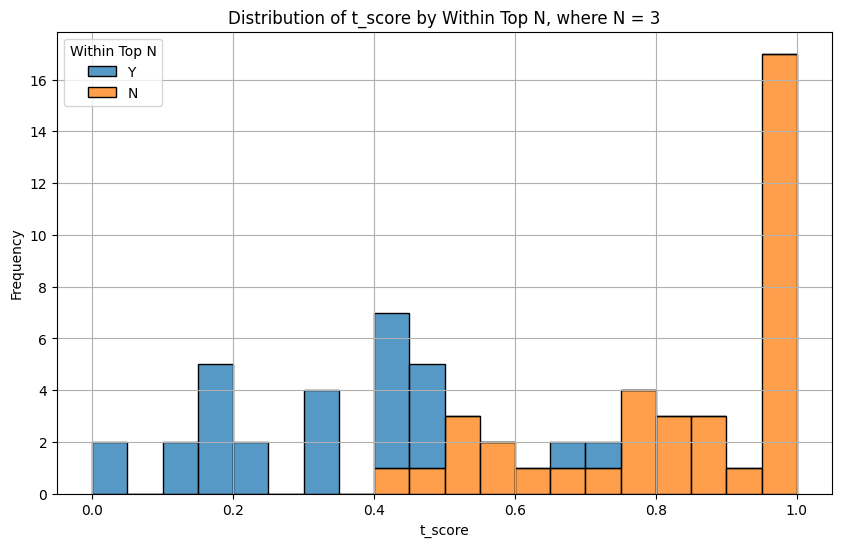

% in Top N: 32.14%
% not in Top N: 45.24%


In [28]:
# !pip install seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of t_score colored by category
plt.figure(figsize=(10, 6))  # Optional: Adjust figure size

# Histogram plot with Seaborn
sns.histplot(data=score_prediction_df, x='t_score', hue='Within Top N', multiple='stack', bins=20, edgecolor='black')  # Adjust bins as needed
plt.title('Distribution of t_score by Within Top N, where N = ' + str(N))  # Optional: Add plot title
plt.xlabel('t_score')  # Optional: Add x-axis label
plt.ylabel('Frequency')  # Optional: Add y-axis label

plt.grid(True)  # Optional: Add grid
plt.show()


# Calculate percentage of rows where column 'B' equals 'N'
count_A_equals_Y = len(score_prediction_df[score_prediction_df['Within Top N'] == 'Y'])
percentage_A_equals_Y = (count_A_equals_Y / len(score_prediction_df)) * 100
count_B_equals_N = len(score_prediction_df[score_prediction_df['Within Top N'] == 'N'])
percentage_B_equals_N = (count_B_equals_N / len(score_prediction_df)) * 100

print(f"% in Top N: {percentage_A_equals_Y:.2f}%")
print(f"% not in Top N: {percentage_B_equals_N:.2f}%")